# MIR Homework 1

### 1. Basic audio signal processing

(a) Plot audio spectrogram

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf


def plot_wav(filename):
    y, sr = librosa.load(filename)
    D = librosa.stft(y, win_length=2048 ,hop_length=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title='Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

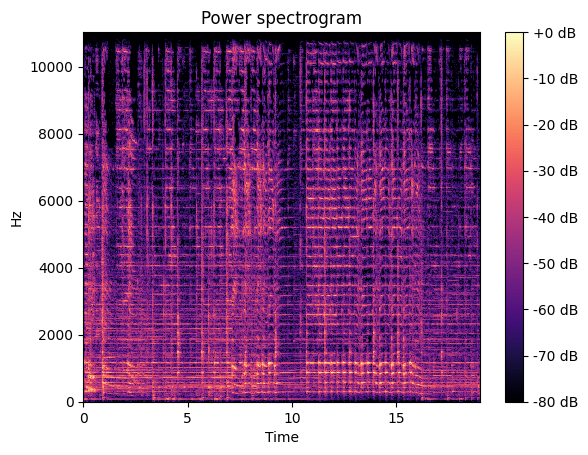

In [22]:
plot_wav("sitar_01.wav")

(b) Instantaneous frequency

$$ x_2(t) = sin(2000t + 10sin(2.5t^2)) $$
$$ f_2(t) = \frac{1}{2\pi}(\frac{d}{dt}(2000t + 10sin(2.5t^2)))$$ 
$$ = \frac{1}{2\pi}(2000 + 10cos(2.5t^2)(5t)) $$
$$ = \frac{1000}{\pi} + \frac{cos(2.5t^2)(25t)}{\pi} $$

(c) Write x1, x2 to WAV file
$$ x_1(t) = sin(2000t^2) $$
$$ x_2(t) = sin(2000t + 10sin(2.5t^2)) $$

Q. Describe what you hear in $x_1$ and $x_2$. <br>
The instantaneous frequency of $x_1$ increases between 0s and 6.28s, then begins to decrease <br>
The instantaneous frequency of $x_2$ fluctuates more as the time procgresses


In [23]:
import math

def x1(t):
    return math.sin(2000*t*t)

def x2(t):
    return math.sin(2000*t + 10*math.sin(2.5*t*t))

In [24]:
samplerate = 8000
x1_wave = [x1(t) for t in np.arange(0, 10, 1/samplerate)]
x2_wave = [x2(t) for t in np.arange(0, 10, 1/samplerate)]
sf.write('x1.wav', x1_wave, samplerate)
sf.write('x2.wav', x2_wave, samplerate)

(d) Plot spectrogram of x1, x2

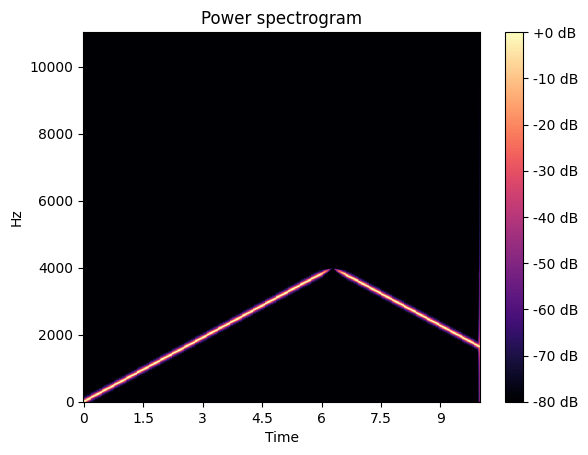

In [25]:
plot_wav('x1.wav')

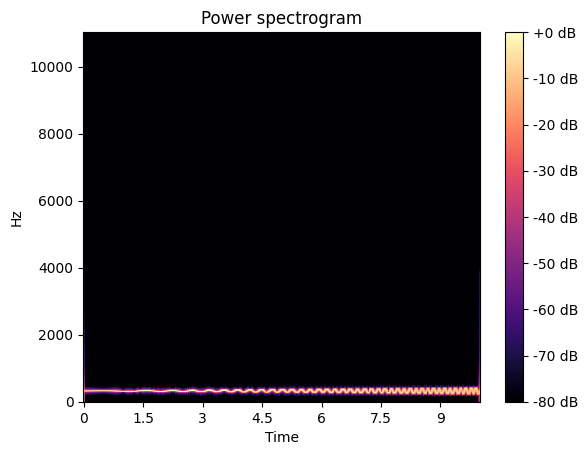

In [26]:
plot_wav('x2.wav')

### 2. Musical Key Detection

(a) Implement K-S key finding algorithm and evaluate RA and WA on SC06 audio recordings in SWD

In [27]:
import scipy

def maxFromChroma(chromaGram, debug=False):
    major = [6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88]
    minor = [6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17]

    noteNames = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

    maxI = 0
    maxcorr = -1
    maxNoteName = ""
    for i in range(24):
        scale = major if i < 12 else minor
        corr = scipy.stats.pearsonr(scale, np.roll(chromaGram, i)).statistic
        noteName = noteNames[i%12] + ":" + ("major" if i < 12 else "minor")

        if corr > maxcorr:
            maxcorr = corr
            maxI = i
            maxNoteName = noteName

        if debug:
            print(noteName, corr)

    return (maxNoteName, maxcorr)

chroma = [432,231,0,405,12,316,4,126,612,0,191,1]
assert maxFromChroma(chroma) == ('E:major', 0.9697081488469904)

In [28]:
def getGlobalChroma(wavfilename, chroma_feat_func):
    x, sr = librosa.load(wavfilename)
    hop_length = 512
    chromagram = chroma_feat_func(y=x, sr=sr, hop_length=hop_length)
    return [sum(n) for n in chromagram]

In [29]:
def drawChromagram(wavfilename):
    x, sr = librosa.load(wavfilename)
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
    fig, ax = plt.subplots(figsize=(15, 3))
    img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    fig.colorbar(img, ax=ax)

In [30]:
gk = pd.read_csv("../SWD/02_Annotations/ann_audio_globalkey.csv", delimiter=";")
sc06 = gk[gk.PerformanceID == "SC06"]

In [31]:
import glob
from pathlib import Path

# test set df
filepaths = sorted(glob.glob("../SWD/01_RawData/audio_wav/*_SC06.wav"))
filenames = [Path(path).stem for path in filepaths]

In [32]:
stft_prediction = [maxFromChroma(getGlobalChroma(path, librosa.feature.chroma_stft))[0] for path in filepaths]
stft_prediction

['C:minor',
 'F:minor',
 'A:minor',
 'D:minor',
 'D#:major',
 'A#:minor',
 'D#:major',
 'C:major',
 'D#:minor',
 'D:minor',
 'F:major',
 'D#:minor',
 'E:major',
 'G:major',
 'D:minor',
 'E:major',
 'C:major',
 'C:minor',
 'F:major',
 'G:minor',
 'A:major',
 'C:major',
 'C#:minor',
 'A#:major']

In [33]:
cqt_prediction = [maxFromChroma(getGlobalChroma(path, librosa.feature.chroma_cqt))[0] for path in filepaths]
cqt_prediction

['C:minor',
 'F:minor',
 'D:minor',
 'D:minor',
 'D#:major',
 'A#:minor',
 'D#:major',
 'G:major',
 'D#:minor',
 'D:minor',
 'F:major',
 'D#:minor',
 'E:major',
 'G:major',
 'D:minor',
 'E:major',
 'C:major',
 'C:minor',
 'A#:major',
 'G:minor',
 'A:major',
 'C:major',
 'F:major',
 'A#:major']

In [34]:
cens_prediction = [maxFromChroma(getGlobalChroma(path, librosa.feature.chroma_cens))[0] for path in filepaths]
cens_prediction

['C:minor',
 'F:minor',
 'D:minor',
 'D:minor',
 'D#:major',
 'A#:minor',
 'D#:major',
 'C:major',
 'D#:minor',
 'D:minor',
 'F:major',
 'D#:minor',
 'E:major',
 'G:major',
 'D:minor',
 'E:major',
 'C:major',
 'C:minor',
 'A#:major',
 'G:minor',
 'A:major',
 'C:major',
 'C#:minor',
 'A#:major']

In [35]:
import re

def format_helper(val):
    if re.match("^[A-G]#?:(min|maj)$", val):
        matchh = re.match("^([A-G]#?):(min|maj)$", val)
        groups = matchh.groups()
        d = {"min":"minor", "maj":"major"}
        mode = d[groups[1]] if groups[1] in d else groups[1]
        return groups[0] + " " + mode
    elif re.match("^[A-G]#?:(minor|major)$", val):
        matchh = re.match("^([A-G]#?):(minor|major)$", val)
        groups = matchh.groups()
        return groups[0] + " " + groups[1]
    else:
        print(val, " not supported")
        return val

def mir_eval_formatter(vals):
    return [format_helper(val) for val in vals]

print(format_helper('C:min'))
print(format_helper('C#:min'))
print(format_helper('C:maj'))
print(format_helper('C#:maj'))

print(format_helper('C:minor'))
print(format_helper('C#:minor'))
print(format_helper('C:major'))
print(format_helper('C#:major'))


# print(mir_eval_formatter(['C:min', 'G:min', 'G:maj']))
# print(mir_eval_formatter(['C:minor', 'F:minor', 'D#:major', 'C:major']))

C minor
C# minor
C major
C# major
C minor
C# minor
C major
C# major


In [36]:
sc06.key.values

array(['C:min', 'G:min', 'D#:min', 'Bb:min', 'D:maj', 'D:min', 'D:min',
       'F:min', 'A:min', 'Bb:min', 'G:maj', 'A:min', 'Db:maj', 'Bb:min',
       'Bb:min', 'Db:maj', 'C:maj', 'C:min', 'G:maj', 'F:min', 'Eb:maj',
       'F:min', 'G:maj', 'G:min'], dtype=object)

In [37]:
ground_truth = mir_eval_formatter(sc06.key.values)
stft_prediction = mir_eval_formatter(stft_prediction)
cqt_prediction = mir_eval_formatter(cqt_prediction)
cens_prediction = mir_eval_formatter(cens_prediction)

Bb:min  not supported
Bb:min  not supported
Db:maj  not supported
Bb:min  not supported
Bb:min  not supported
Db:maj  not supported
Eb:maj  not supported


In [46]:
import mir_eval
from sklearn.metrics import accuracy_score


def raw_accuracy(ground_truth, prediction):
    if len(ground_truth) != len(prediction):
        print("ground truth must have the same length as prediction")
        return
    return accuracy_score(ground_truth, prediction)

def weighted_accuracy(ground_truth, prediction):
    if len(ground_truth) != len(prediction):
        print("ground truth must have the same length as prediction")
        return
    n = len(ground_truth)
    score = 0
    for i in range(n):
        score += mir_eval.key.weighted_score(ground_truth[i], prediction[i])
    return score / n

In [47]:
stft_prediction

['C minor',
 'F minor',
 'A minor',
 'D minor',
 'D# major',
 'A# minor',
 'D# major',
 'C major',
 'D# minor',
 'D minor',
 'F major',
 'D# minor',
 'E major',
 'G major',
 'D minor',
 'E major',
 'C major',
 'C minor',
 'F major',
 'G minor',
 'A major',
 'C major',
 'C# minor',
 'A# major']

In [48]:
print(raw_accuracy(ground_truth, stft_prediction))
print(raw_accuracy(ground_truth, cqt_prediction))
print(raw_accuracy(ground_truth, cens_prediction))

0.125
0.125
0.125


In [49]:
print(weighted_accuracy(ground_truth, stft_prediction))
print(weighted_accuracy(ground_truth, cqt_prediction))
print(weighted_accuracy(ground_truth, cens_prediction))

ValueError: 'Bb:min' is not in the form '(key) (mode)' or 'X'

(b) Local key detection

(c) Apply over-segmentation under-segmentation and average-segmentation on local key detection of SWD

(d) Propose any better global and local key detection algorithm (Bonus)